<a href="https://colab.research.google.com/github/haaaein/detection_miniproject/blob/main/mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **패키지 불러오기**

In [ ]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [ ]:
import urllib
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
import os 
from PIL import Image
import random
import xml.etree.ElementTree as ET 
import time
import requests
from skimage.transform import resize

from bs4 import BeautifulSoup
import matplotlib.patches as patches
import albumentations as A

### **directory 연결**

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# path of images directory
dir_path  = '../gdrive/My Drive/detection_miniproject/archive/images'

# path of xml files directory
xml_path = "../gdrive/My Drive/detection_miniproject/archive/annotations"

#List of Image file name 
file_list = os.listdir(dir_path)

# How many image files?
print('There are total {} images.'.format(len(file_list)))

There are total 853 images.


### **함수 정의**
- **read_annot** : xml 파일을 일어오는 함수
- **draw_boxes**:  bounding box를 그리는 함수

In [ ]:
def read_annot(file_name, xml_dir): # file_name, xml_dir을 input으로 받아 bbox, labels를 return 
    
    bbox = [] # 마스크의 바운딩 박스 좌표를 담음
    labels = [] # with_mask면 2, no_mask 1, mask_weared_incorrect 3
    
    annot_path = os.path.join(xml_dir, file_name[:-3]+'xml')
    tree = ET.parse(annot_path)
    root = tree.getroot()

    # 각 마스크의 바운딩 박스 좌표
    for boxes in root.iter('object'):
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        label = boxes.find('name').text

        bbox.append([xmin,ymin,xmax,ymax])

        if label == 'with_mask':
            label_idx = 2
        elif label == 'without_mask':
            label_idx = 1
        else :
            label_idx = 3
        labels.append(label_idx)
        
    return bbox, labels

def draw_boxes(img, boxes, labels, thickness=2): # thickness : bounding box의 두께 2로 지정
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 
    text = []
    for box,label in zip(boxes,labels):
        box = [int(x) for x in box]
        if label == 2: # with_mask 면 Cyan bounding box
            color = (255,255,0) 
            text.append("with_mask")
        elif label == 1: # with_mask가 아니면 Magenta bounding box
            color = (255,0,225) # red
            text.append("without_mask")
        else : #weared_incorrect면 yellow bounding box
            color = (0,215,255) #orange
            text.append("mask_weared_incorrect")
        cv2.rectangle(img, (box[0],box[1]),(box[2],box[3]),color,thickness)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB), box[0], box[1], text

### **Class 정의**

In [ ]:
class dataset(Dataset):
    def __init__(self, image_list, image_dir, xml_dir):
        self.image_list = image_list
        self.image_dir = image_dir
        self.xml_dir = xml_dir

    def __len__(self): # 데이터 세트의 크기를 제공하는 메소드
     return len(self.image_list)
       
    def __getitem__(self, idx): 
        """
        Load the image
        """
        img_name = self.image_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        img = transforms.ToTensor()(img)

        """
        build the target dict
        """
        
        bbox, labels = read_annot(img_name, self.xml_dir)
        boxes = torch.as_tensor(bbox, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        area = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
        area = torch.as_tensor(area, dtype=torch.float32)
        iscrowd = torch.zeros((len(bbox),), dtype=torch.int64)
        
        # target : dictionary형태로 생성
        target = {}
        
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowed'] = iscrowd
        return img , target
                    


### **데이터셋 생성**

In [ ]:
mask_dataset = dataset(file_list, dir_path, xml_path)

# 학습 데이터를 학습용 모델에 일괄적으로 업로드, 이를 위해 PyTorch의 DataLoader 유틸리티 사용
def collate_fn(batch):
    return tuple(zip(*batch))

mask_loader = DataLoader(mask_dataset,
                        batch_size=10,
                        shuffle=True,
                        num_workers=2,
                        collate_fn=collate_fn)

### **모델 불러오기**

In [ ]:
def get_model(num_classes) :
    # output_shape에 원하는 클래스 개수를 설정하고 COCO 데이터셋을 ResNet50으로 미리 학습되어 있는 모델을 읽어오기
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # 분류기에서 사용할 입력 특징의 차원 정보 얻기
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # 미리 학습된 모델의 머리 부분을 새로운 것으로 교체
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

# 모델을 gpu나 cpu로 옮기기
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

# class 개수를 4개로 설정한 후 모델을 불러오기
model = get_model(4).to(device)

# 파라미터를 설정하여 옵티마이저(optimizer) 만들기
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = 0.005, momentum = 0.9, weight_decay = 0.0005)
# optimizer = torch.optim.Adam(params, lr=0.01)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
# Setting up the model

num_classes = 4 # background, without_mask, with_mask, mask_weard_incorrect

# torchvision.models.detection에서는 Faster R-CNN API를 제공하고 있어 쉽게 구현 가능
# ResNet50으로 미리 학습되어 있는 모델을 읽어오기
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# 분류기에서 사용할 입력 특징의 차원 정보 얻기
in_features = model.roi_heads.box_predictor.cls_score.in_features

# 미리 학습된 모델의 머리 부분을 새로운 것으로 교체
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model = model.to(device)


In [ ]:

params = [p for p in model.parameters() if p.requires_grad]

# 신경망 훈련에는 SGD, Adam등의 상황에 따라 다양한 optimizer가 사용된다.
# optimizer = torch.optim.Adam(params, lr=0.01)
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0005) 
# momentum값은 0.9에서 시작하며, 0.95, 0.99로 증가시키며 사용!, weight decay는 모델의 weight의 제곱합을 패널티 텀으로 주어 (=제약을 걸어) loss를 최소화 하는 것을 말한다

# 학습 횟수 30으로 지정
num_epochs=30

In [ ]:
#v5 모델 불러오기
model.load_state_dict(torch.load('../gdrive/My Drive/detection_miniproject/model_30.pt'))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### **Train Start**

In [ ]:
from tqdm.notebook import tqdm

# Main training function
loss_list = []

# 학습 횟수 30으로 지정
num_epoch = 30
print('---------------------------train start---------------------------')

for epoch in range(num_epoch):
    epoch_loss = 0

    loss_sub_list = []
    start = time.time()

    for images, targets in tqdm(mask_loader):
        images = list(image.to(device) for image in images)
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
        
        model.train()

        predict = model(images, targets) #predict
        losses = sum(loss for loss in predict.values())

        loss_value = losses.item()
        loss_sub_list.append(loss_value)
        
        # update optimizer and learning rate
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses

    end = time.time()
        
    #print the loss of epoch
    epoch_loss = np.mean(loss_sub_list)
    loss_list.append(epoch_loss)

    print(epoch+1, '/', num_epoch, 'Epoch loss: {:.3f} , time used: ({:.1f}s)'.format(epoch_loss, end-start))
    if epoch_loss < 0.1 :
        print('early stop')
        break

---------------------------train start---------------------------


  0%|          | 0/171 [00:00<?, ?it/s]

1 / 2 Epoch loss: 0.424 , time used: (935.3s)


  0%|          | 0/171 [00:00<?, ?it/s]

2 / 2 Epoch loss: 0.275 , time used: (904.4s)


### **학습 모델 저장**

In [ ]:
# model 불러와서 train 안시켰을때는 안해도 됩니다!!!
# Save model
torch.save(model, 'model.pt')

# Load model
model = torch.load('../gdrive/My Drive/detection_miniproject/model.pt')
model.eval()

### **예측결과 확인**

In [ ]:
# helper function for single image prediction
def single_img_predict(img, nm_thrs = 0.3, score_thrs=0.8):
    test_img = transforms.ToTensor()(img)
    model.eval()
    
    with torch.no_grad():
        predictions = model(test_img.unsqueeze(0).to(device))
        
    test_img = test_img.permute(1,2,0).numpy()
    
    # non-max supression
    keep_boxes = torchvision.ops.nms(predictions[0]['boxes'].cpu(),predictions[0]['scores'].cpu(),nm_thrs)
    
    # Only display the bounding boxes which higher than the threshold
    score_filter = predictions[0]['scores'].cpu().numpy()[keep_boxes] > score_thrs
    
    # get the filtered result
    test_boxes = predictions[0]['boxes'].cpu().numpy()[keep_boxes][score_filter]
    test_labels = predictions[0]['labels'].cpu().numpy()[keep_boxes][score_filter]
    test_score = predictions[0]['scores'].cpu().numpy()[keep_boxes][score_filter]

    
    return test_img, test_boxes, test_labels, test_score

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


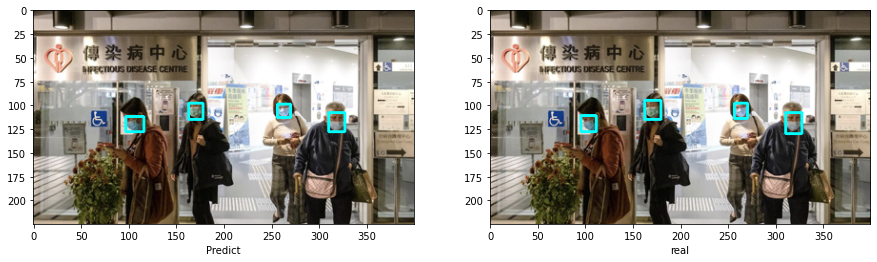

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


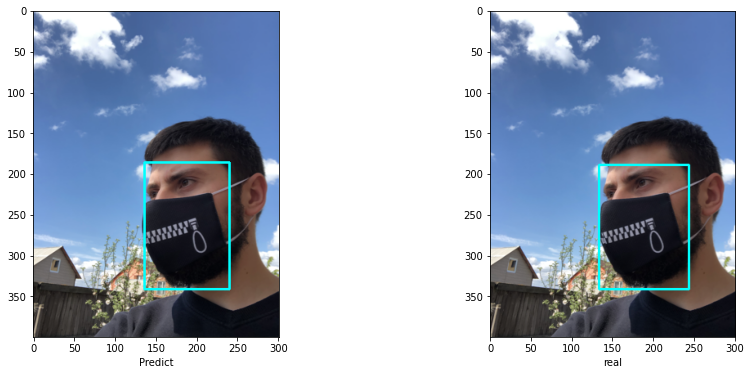

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


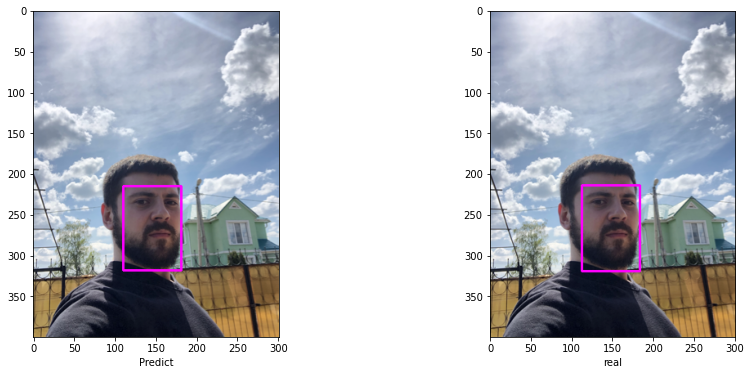

In [ ]:
from tarfile import NUL

for idx in range(3) :
    idx = random.randint(1,len(file_list))
    test_img = Image.open(os.path.join(dir_path,file_list[idx])).convert('RGB')

    # Prediction
    test_img, test_boxes, test_labels, test_score = single_img_predict(test_img)
    test_output, xmin, ymin, text = draw_boxes(test_img, test_boxes,test_labels)

    # Draw the bounding box of ground truth
    bbox, labels  = read_annot(file_list[idx], xml_path)
    #draw bounding boxes on the image
    gt_output, xmin, ymin, text = draw_boxes(test_img, bbox,labels)

    # Display the result
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
    ax1.set_xlabel('Predict') # 모델의 예측 결과
    ax1.imshow(test_output)

    ax2.set_xlabel('real') # 실제 바운딩 박스 위치
    ax2.imshow(gt_output)
    plt.show()

### **사진에 라벨과 스코어 출력**

In [ ]:
def print_score(img, text_boxes, test_score):
  # Display the result
  fig, (ax1) = plt.subplots(1,figsize=(15,6))
  ax1.set_xlabel('Predict') # 모델의 예측 결과
  ax1.imshow(img)

  for i in range(len(test_boxes)):
    xmin = test_boxes[i][0]
    ymin = test_boxes[i][1]
    score = " : " + str(round(test_score[i] * 100, 2)) + "%"
    text_score = text[i] + score
    
    if text[i] == "without_mask":
      text_score = "no_mask" + score
      ax1.text(xmin + 50, ymin - 20, f"{text_score}",horizontalalignment='center', verticalalignment='center',fontsize=10,color='black', backgroundcolor='Magenta')
    elif text[i] == "with_mask":
      ax1.text(xmin + 50, ymin - 20, f"{text_score}",horizontalalignment='center', verticalalignment='center',fontsize=10,color='black', backgroundcolor='Cyan')
    else : 
      text_score = "wrong_use" + score
      ax1.text(xmin + 50, ymin - 20, f"{text_score}",horizontalalignment='center', verticalalignment='center',fontsize=10,color='black', backgroundcolor='Yellow')

### 이미지 비율로 축소 ###

In [ ]:
def resize_img(img):
  tp = str(type(img))

  if (tp.endswith("Image'>")):
    ratio = 800/img.size[0]
    width = img.size[0]*ratio
    height = img.size[1]*ratio
    res_img = img.resize((int(width), int(height)))

  else:
    ratio = 800/img.shape[1]
    width = img.shape[1]*ratio
    height = img.shape[0]*ratio
    res_img = cv2.resize(img, dsize=(int(width), int(height)))
  return res_img

### **Mask Detection Test**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


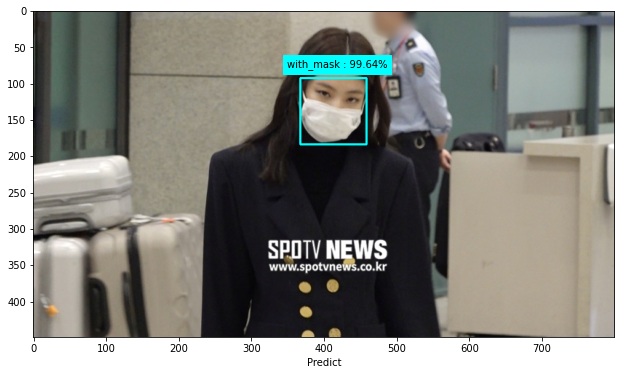

In [ ]:
url = 'http://ph.spotvnews.co.kr/news/photo/201912/333524_415444_1310.jpg'
test_img = Image.open(requests.get(url, stream=True).raw).convert('RGB')

#resize image by ratio
res_img = resize_img(test_img)
# Prediction
test_img, test_boxes, test_labels, test_score = single_img_predict(res_img)
#print(test_score)
test_output, xmin, ymin, text = draw_boxes(test_img, test_boxes, test_labels)

# Display the result
print_score(test_output, test_boxes, test_score)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


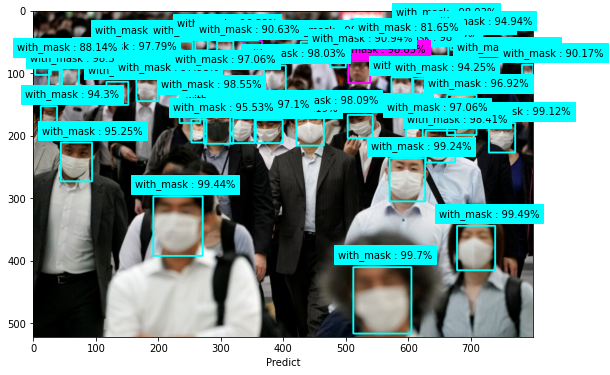

In [ ]:
url = 'http://flexible.img.hani.co.kr/flexible/normal/970/633/imgdb/original/2020/0529/5815907375869244.jpg'
test_img = Image.open(requests.get(url, stream=True).raw).convert('RGB')

#resize image by ratio
res_img = resize_img(test_img)
#Prediction
test_img, test_boxes, test_labels, test_score = single_img_predict(res_img)
#draw boxes
test_output, xmin, ymin, text = draw_boxes(test_img, test_boxes, test_labels)

#Display the result
print_score(test_output, test_boxes, test_score)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


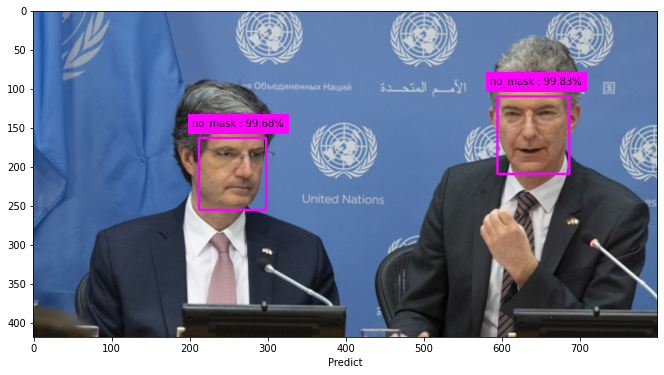

In [ ]:
url = 'https://img.seoul.co.kr/img/upload/2019/03/02/SSI_20190302101853_O2.jpg'
test_img = Image.open(requests.get(url, stream=True).raw).convert('RGB')

#resize image by ratio
res_img = resize_img(test_img)
#Prediction
test_img, test_boxes, test_labels, test_score = single_img_predict(res_img)
#draw boxes
test_output, xmin, ymin, text = draw_boxes(test_img, test_boxes, test_labels)

#Display the result
print_score(test_output, test_boxes, test_score)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


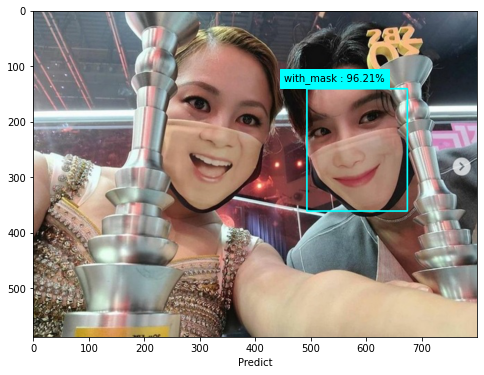

In [ ]:
url = 'https://image.newdaily.co.kr/site/data/img/2020/12/24/2020122400212_0.jpg'
test_img = Image.open(requests.get(url, stream=True).raw).convert('RGB')

#resize image by ratio
res_img = resize_img(test_img)
#Prediction
test_img, test_boxes, test_labels, test_score = single_img_predict(res_img)
#draw boxes
test_output, xmin, ymin, text = draw_boxes(test_img, test_boxes, test_labels)

#Display the result
print_score(test_output, test_boxes, test_score)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


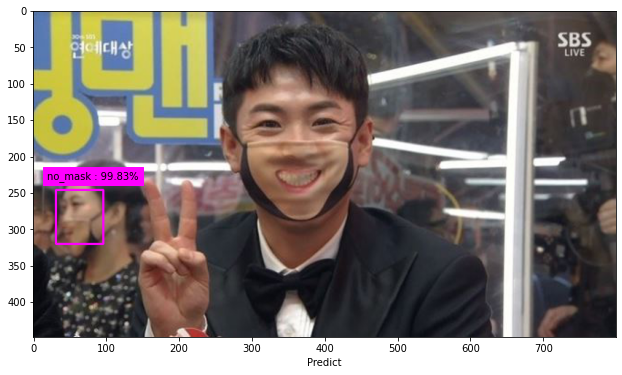

In [ ]:
url = 'http://image.kmib.co.kr/online_image/2020/1220/611817110015342946_2.jpg'
test_img = Image.open(requests.get(url, stream=True).raw).convert('RGB')

#resize image by ratio
res_img = resize_img(test_img)
#Prediction
test_img, test_boxes, test_labels, test_score = single_img_predict(res_img)
#draw boxes
test_output, xmin, ymin, text = draw_boxes(test_img, test_boxes, test_labels)

#Display the result
print_score(test_output, test_boxes, test_score)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


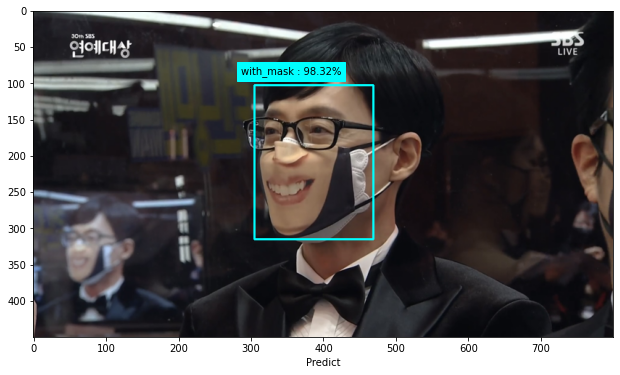

In [ ]:
url = 'http://file3.instiz.net/data/cached_img/upload/2020/12/19/21/1d938ec399c1d492ecaedcbf1683a03b.jpg'
test_img = Image.open(requests.get(url, stream=True).raw).convert('RGB')

#resize image by ratio
res_img = resize_img(test_img)
#Prediction
test_img, test_boxes, test_labels, test_score = single_img_predict(res_img)
#draw boxes
test_output, xmin, ymin, text = draw_boxes(test_img, test_boxes, test_labels)

#Display the result
print_score(test_output, test_boxes, test_score)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


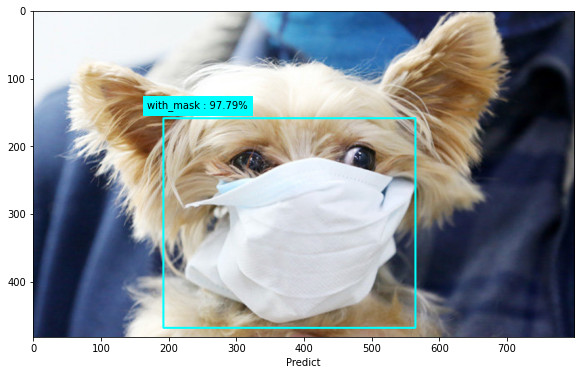

In [ ]:
url = 'https://dimg.donga.com/ugc/CDB/WEEKLY/Article/5f/1e/8d/da/5f1e8dda0414d2738de6.jpg'
test_img = Image.open(requests.get(url, stream=True).raw).convert('RGB')

#resize image by ratio
res_img = resize_img(test_img)
#Prediction
test_img, test_boxes, test_labels, test_score = single_img_predict(res_img)
#draw boxes
test_output, xmin, ymin, text = draw_boxes(test_img, test_boxes, test_labels)

#Display the result
print_score(test_output, test_boxes, test_score)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


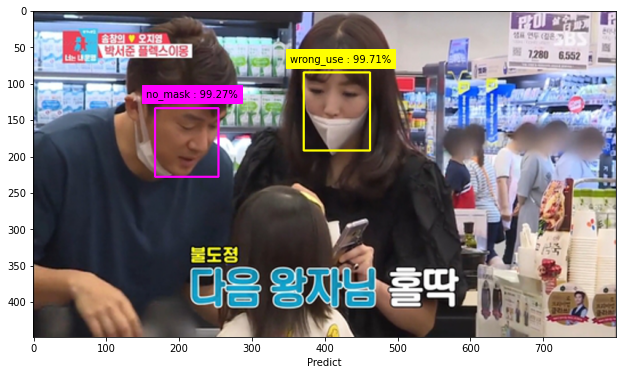

In [ ]:
url = 'https://img.segye.com/content/image/2020/09/01/20200901518728.jpg'
test_img = Image.open(requests.get(url, stream=True).raw).convert('RGB')

#resize image by ratio
res_img = resize_img(test_img)
#Prediction
test_img, test_boxes, test_labels, test_score = single_img_predict(res_img)
#draw boxes
test_output, xmin, ymin, text = draw_boxes(test_img, test_boxes, test_labels)

#Display the result
print_score(test_output, test_boxes, test_score)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


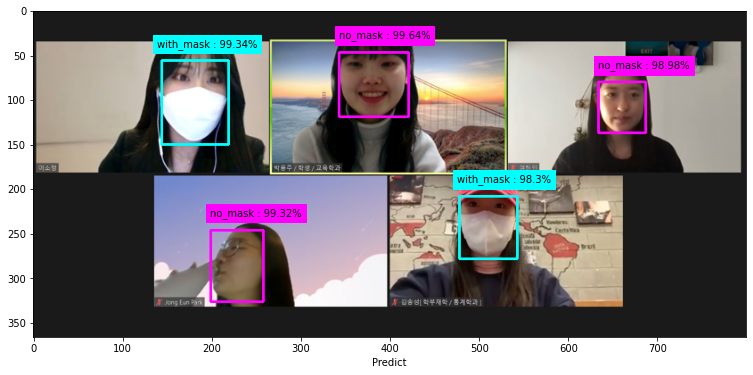

In [ ]:
url = '../gdrive/My Drive/detection_miniproject/boaz_test.png'
test_img = Image.open(url).convert('RGB')

#resize image by ratio
res_img = resize_img(test_img)
#Prediction
test_img, test_boxes, test_labels, test_score = single_img_predict(res_img)
#draw boxes
test_output, xmin, ymin, text = draw_boxes(test_img, test_boxes, test_labels)

#Display the result
print_score(test_output, test_boxes, test_score)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


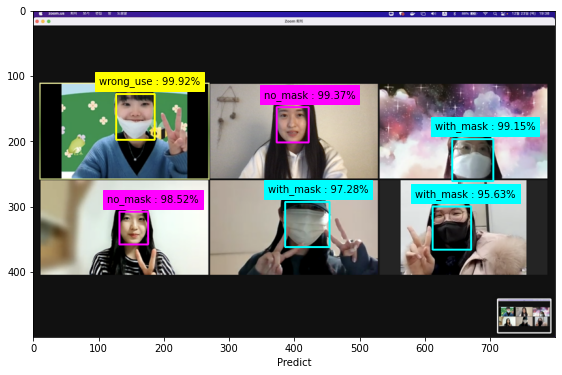

In [ ]:
url = '../gdrive/My Drive/detection_miniproject/test1.png'
test_img = Image.open(url).convert('RGB')

#resize image by ratio
res_img = resize_img(test_img)
#Prediction
test_img, test_boxes, test_labels, test_score = single_img_predict(res_img)
#draw boxes
test_output, xmin, ymin, text = draw_boxes(test_img, test_boxes, test_labels)

#Display the result
print_score(test_output, test_boxes, test_score)

In [ ]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

for fn in uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    
test_img = fn #image 파일 이름 저장

Saving 스크린샷 2021-12-30 오후 7.49.56.png to 스크린샷 2021-12-30 오후 7.49.56.png
User uploaded file "스크린샷 2021-12-30 오후 7.49.56.png" with length 7069129 bytes


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


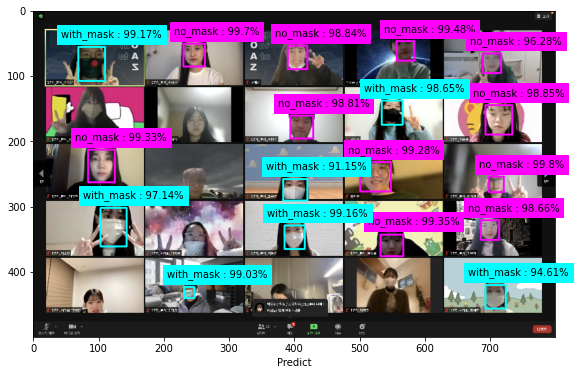

In [ ]:
test_img = cv2.imread("./" + test_img)
img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB) 

#resize image by ratio
res_img = resize_img(img)
#Prediction
test_img, test_boxes, test_labels, test_score = single_img_predict(res_img)
#draw boxes
test_output, xmin, ymin, text = draw_boxes(test_img, test_boxes, test_labels)

#Display the result
print_score(test_output, test_boxes, test_score)
